### 【#11】クロス特徴量(FOLD/SEED)

In [1]:
# 通常の pandas 動作が倍速になる
%load_ext cudf.pandas

In [2]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import os
import cudf
from cuml.preprocessing import TargetEncoder

# データフレーム読み込み
train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
TARGET = "BeatsPerMinute"

In [3]:
# 前処理前の相関分布を確認
import seaborn as sns
import matplotlib.pyplot as plt

# BPMを周期的に扱う
train_df["BPM_sin60"] = np.sin(2*np.pi*train_df[TARGET]/60)
train_df["BPM_cos60"] = np.cos(2*np.pi*train_df[TARGET]/60)

# 相関係数の確認
df_corr = train_df.drop("id",axis=1).corr()
df_corr[["BeatsPerMinute","BPM_sin60","BPM_cos60"]]
# グラフ表示
# fig, ax = plt.subplots(figsize=(8, 6)) 
# sns.heatmap(df_corr, mask=df_corr.isnull(), cmap="inferno", square=True, vmax=1, vmin=-1, center=0, annot=True)

,BeatsPerMinute,BPM_sin60,BPM_cos60
RhythmScore,0.005440,0.001740,0.000858
AudioLoudness,-0.003327,0.003813,-0.001307
VocalContent,0.004876,-0.000153,0.000820
AcousticQuality,-0.000820,-0.002490,0.000240
InstrumentalScore,0.001900,0.000799,0.002295
LivePerformanceLikelihood,0.003471,0.000891,0.003175
MoodScore,0.007059,0.001023,0.003620
TrackDurationMs,0.006637,-0.002392,0.003216
Energy,-0.004375,0.006441,0.000348
BeatsPerMinute,1.000000,0.072929,0.016652


In [4]:
# from sklearn.feature_selection import mutual_info_regression

# # 相互情報量の計算
# mi_scores = mutual_info_regression(train_df.drop(["id",TARGET],axis=1), 
#                                    train_df[TARGET], random_state=42)

# # 結果をDataFrame化してソート
# mi_df = pd.DataFrame({
#     "feature": train_df.drop(["id",TARGET],axis=1).columns,
#     "mutual_info": mi_scores
# }).sort_values(by="mutual_info", ascending=False)

# print(mi_df)

In [5]:
# 初期値に戻す
train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")

In [6]:
from sklearn.preprocessing import MinMaxScaler

## [dB]表記を直値に戻す LdBFS = 20*log10(|x|/xmax)
# 戻すには 10^(dBFS/20) * xmax
train_df["AudioLoudness"] = 10**(train_df["AudioLoudness"]/20)
test_df["AudioLoudness"] = 10**(test_df["AudioLoudness"]/20)

# TrackDurationMs (ms → minute)
train_df["TrackDurationMs"] = train_df["TrackDurationMs"] / 1000 / 60
test_df["TrackDurationMs"] = test_df["TrackDurationMs"] / 1000 / 60

# 規格化する
scaler = MinMaxScaler()
for col in train_df.drop(["id",TARGET],axis=1).columns:

    train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1, 1))
    test_df[col] = scaler.transform(test_df[col].values.reshape(-1, 1))

In [7]:
# データ結合
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [8]:
# bin化する
bins = [0, 0.2, 0.4, 0.6, 0.8, all_df.drop(["id",TARGET],axis=1).max().max()]
labels = ["VeryLow","Low","Mid","High","VeryHigh"]
# labels = list(range(5))
for col in train_df.drop(["id",TARGET],axis=1).columns:
    all_df[col+"_bin"] = pd.cut(all_df[col], bins=bins,
                                labels=labels, include_lowest=True).astype("object")

In [9]:
# カテゴリ列と数値列に分ける
CATS = []
NUMS = []
for c in (all_df.drop(["id",TARGET],axis=1)).columns:
    t = "CAT"
    if all_df[c].dtype=='object':
        CATS.append(c)
    else:
        NUMS.append(c)
        t = "NUM"
    n = all_df[c].nunique()
    na = all_df[c].isna().sum()
    print(f"[{t}] {c} has {n} unique and {na} NA")
print("CATS:", CATS )
print("NUMS:", NUMS )

[NUM] RhythmScore has 420960 unique and 0 NA
[NUM] AudioLoudness has 408208 unique and 0 NA
[NUM] VocalContent has 297350 unique and 0 NA
[NUM] AcousticQuality has 353187 unique and 0 NA
[NUM] InstrumentalScore has 285676 unique and 0 NA
[NUM] LivePerformanceLikelihood has 364273 unique and 0 NA
[NUM] MoodScore has 400518 unique and 0 NA
[NUM] TrackDurationMs has 496440 unique and 0 NA
[NUM] Energy has 11980 unique and 0 NA
[CAT] RhythmScore_bin has 5 unique and 0 NA
[CAT] AudioLoudness_bin has 5 unique and 0 NA
[CAT] VocalContent_bin has 5 unique and 0 NA
[CAT] AcousticQuality_bin has 5 unique and 0 NA
[CAT] InstrumentalScore_bin has 5 unique and 0 NA
[CAT] LivePerformanceLikelihood_bin has 5 unique and 0 NA
[CAT] MoodScore_bin has 5 unique and 0 NA
[CAT] TrackDurationMs_bin has 5 unique and 0 NA
[CAT] Energy_bin has 5 unique and 0 NA
CATS: ['RhythmScore_bin', 'AudioLoudness_bin', 'VocalContent_bin', 'AcousticQuality_bin', 'InstrumentalScore_bin', 'LivePerformanceLikelihood_bin', 'Moo

In [10]:
# カテゴリ列をラベルエンコードする
# NUMS：数値列、NUMS2：カテゴリ数、CATS1：カテゴリ数
CATS1 = [] # 数値列
SIZES = {} # カテゴリ数

for c in NUMS + CATS:
    n = c
    # 数値列のとき
    if c in NUMS: 
        n = f"{c}2"
        CATS1.append(n)
    # カテゴリ列のとき、ラベルエンコード
    all_df[n],_ = all_df[c].factorize()
    # カテゴリ数
    SIZES[n] = all_df[n].max()+1

    # print(c)
    all_df[c] = all_df[c].astype('int32')
    all_df[n] = all_df[n].astype('int32')

print("New CATS:", CATS1 )
print("Cardinality of all CATS:", SIZES )

New CATS: ['RhythmScore2', 'AudioLoudness2', 'VocalContent2', 'AcousticQuality2', 'InstrumentalScore2', 'LivePerformanceLikelihood2', 'MoodScore2', 'TrackDurationMs2', 'Energy2']
Cardinality of all CATS: {'RhythmScore2': 420960, 'AudioLoudness2': 408208, 'VocalContent2': 297350, 'AcousticQuality2': 353187, 'InstrumentalScore2': 285676, 'LivePerformanceLikelihood2': 364273, 'MoodScore2': 400518, 'TrackDurationMs2': 496440, 'Energy2': 11980, 'RhythmScore_bin': 5, 'AudioLoudness_bin': 5, 'VocalContent_bin': 5, 'AcousticQuality_bin': 5, 'InstrumentalScore_bin': 5, 'LivePerformanceLikelihood_bin': 5, 'MoodScore_bin': 5, 'TrackDurationMs_bin': 5, 'Energy_bin': 5}


In [11]:
# カラムペアの作成
from itertools import combinations

pairs = combinations(CATS + CATS1, 2)
new_cols = {}
CATS2 = []

for c1, c2 in pairs:
    name = "_".join(sorted((c1, c2)))
    new_cols[name] = all_df[c1] * SIZES[c2] + all_df[c2]
    CATS2.append(name)
if new_cols:
    new_df = pd.DataFrame(new_cols)         
    all_df = pd.concat([all_df, new_df], axis=1) 

print(f"Created {len(CATS2)} new CAT columns")

Created 153 new CAT columns


In [12]:
# カウントエンコード
# yの値ではなく、存在しか使っていない。リークにはならない
CE = []
CC = CATS+CATS1+CATS2

print(f"Processing {len(CC)} columns... ",end="")
for i,c in enumerate(CC):
    if i%10==0: print(f"{i}, ",end="")
    tmp = all_df.groupby(c).BeatsPerMinute.count()
    tmp = tmp.astype('int32')
    tmp.name = f"CE_{c}"
    CE.append( f"CE_{c}" )
    all_df = all_df.merge(tmp, on=c, how='left')
print()

Processing 171 columns... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 


In [13]:
# メモリ開放
import gc
del tmp
gc.collect()

0

In [14]:
# データ分割
train = all_df.iloc[:len(train_df)]
test = all_df.iloc[len(train_df):]

In [15]:
# yがint64なのでint32に変換する
train[TARGET] = train[TARGET].astype("int32")

In [16]:
# # 前処理前の相関分布を確認
# import seaborn as sns
# import matplotlib.pyplot as plt

# # BPMを周期的に扱う
# train["BPM_sin60"] = np.sin(2*np.pi*train[TARGET]/60)
# train["BPM_cos60"] = np.cos(2*np.pi*train[TARGET]/60)

In [17]:
# # 1. inf を NaN に変換
# train_clean = train.replace([np.inf, -np.inf], np.nan)

# # 2. NaN を埋める（全部0にする例）
# train_clean = train_clean.fillna(0)

# # 3. 分散ゼロの列を除去
# non_constant_cols = train_clean.loc[:, train_clean.std() != 0]

# # 相関係数の確認
# df_corr = non_constant_cols.drop("id",axis=1).corr()

In [18]:
# # BeatsPerMinuteでソート
# df_corr["BeatsPerMinute"].sort_values(ascending=False)[:5]

In [19]:
# # BPM_sin60でソート
# df_corr["BPM_sin60"].sort_values(ascending=False)[:5]

In [20]:
# # BPM_cos60でソート
# df_corr["BPM_cos60"].sort_values(ascending=False)[:5]

In [21]:
###################################################
############ LightGBM with OOF Target Encoding (Multi-Seed) ###
###################################################
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from cuml.preprocessing import TargetEncoder
import cudf
import warnings
import gc
warnings.filterwarnings("ignore")

# -----------------------------------
# 複数シード設定
# -----------------------------------
seeds = [42, 52, 62]

# 学習・予測格納用
pred_lgb = np.zeros(len(train))
pred_lgb_test = np.zeros(len(test))
models_lgb = []
evals_result_lgb = {}

# 入力データ
X = train.drop(["id", TARGET], axis=1).copy()
y = train[TARGET].copy()
test_ = test.drop(["id",TARGET], axis=1).copy()

# LightGBMパラメータ
lgbm_params = {
    'objective': 'regression',
    'device': 'gpu',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,   # デフォルト = 0.1
    'num_leaves': 31,        # デフォルト = 31, 木にある分岐の個数
    'max_depth': 7,          # デフォルト = -1, 木の深さ制限
    'feature_fraction': 0.7, # デフォルト = 1.0, 特徴量の*100%使用
    'bagging_fraction': 0.7, # デフォルト:1.0
    'bagging_freq': 5,       # デフォルト:0
    'min_data_in_leaf': 200, # デフォルト:20 葉ごとの分岐数
    'lambda_l1': 0.1,        # デフォルト = 0, L1正則化
    'lambda_l2': 1.0,        # デフォルト = 0, L2正則化
    'max_bin': 255,          # デフォルト = 255, ビン数の最大値
    'verbosity': -1          # 学習途中の表示(-1:表示しない)
}

# -----------------------------------
# fold数
# -----------------------------------
n_splits = 7

# -----------------------------------
# 複数シードでループ
# -----------------------------------
for seed in seeds:
    print(f"\n########### Seed {seed} ###########\n")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print("#"*25)
        print(f"### Fold {fold+1}")
        print("#"*25)

        X_train = X.iloc[train_idx,:].copy()
        y_train = y.iloc[train_idx].copy()
        X_valid = X.iloc[valid_idx,:].copy()
        y_valid = y.iloc[valid_idx].copy()
        X_test = test_.copy()

        # -----------------------------------
        # ターゲットエンコーディング
        # -----------------------------------
        CC = CATS1 + CATS2
        print(f"Target encoding {len(CC)} features... ", end="")
        for i, c in enumerate(CC):
            if i % 10 == 0: print(f"{i}, ", end="")
            TE0 = TargetEncoder(n_folds=10, smooth=10, split_method='random', stat='mean')
            X_train[c] = TE0.fit_transform(X_train[c], y_train).astype('float32')
            X_valid[c] = TE0.transform(X_valid[c]).astype('float32')
            X_test[c] = TE0.transform(X_test[c]).astype('float32')
        print()
        del TE0
        gc.collect()

        # CC以外のカテゴリ変換
        for c in CATS:
            if c not in CC:
                X_train[c] = X_train[c].astype('category')
                X_valid[c] = X_valid[c].astype('category')
                X_test[c]  = X_test[c].astype('category')  

        # -----------------------------------
        # データセット
        # -----------------------------------
        lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=CATS)
        lgb_valid = lgb.Dataset(X_valid, y_valid, categorical_feature=CATS)

        # -----------------------------------
        # 学習
        # -----------------------------------
        model_lgb = lgb.train(
            lgbm_params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=[lgb_train, lgb_valid],
            valid_names=["train", "valid"],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.record_evaluation(evals_result_lgb),
                lgb.log_evaluation(100)
            ]
        )

        # -----------------------------------
        # 予測（fold平均 + seed平均）
        # -----------------------------------
        pred_lgb[valid_idx] += model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration) / len(seeds)
        pred_lgb_test += model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration) / (len(seeds) * n_splits)

        # モデル保存
        models_lgb.append(model_lgb)

        # メモリ解放
        del X_train, X_valid
        gc.collect()

        import numba.cuda as cuda
        cuda.current_context().deallocations.clear()


########### Seed 42 ###########

#########################
### Fold 1
#########################
Target encoding 162 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[100]	train's rmse: 26.4361	valid's rmse: 26.4809
[200]	train's rmse: 26.4115	valid's rmse: 26.4807
#########################
### Fold 2
#########################
Target encoding 162 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 
[100]	train's rmse: 26.4486	valid's rmse: 26.403
[200]	train's rmse: 26.4235	valid's rmse: 26.4028
[300]	train's rmse: 26.4004	valid's rmse: 26.4026
#########################
### Fold 3
#########################
Target encoding 162 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 
[100]	train's rmse: 26.4315	valid's rmse: 26.5036
[200]	train's rmse: 26.4061	valid's rmse: 26.5045
#########################
### Fold 4
#########################
Target encoding 162 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 
[100]	train's rmse: 26.4172	valid's rmse: 26.5971
#########################
### Fold 5
#########################
Target encoding 162 features

LGB: RMSE score = 26.461442389743407


<Axes: title={'center': 'LightGBM RMSE'}, xlabel='Iterations', ylabel='rmse'>

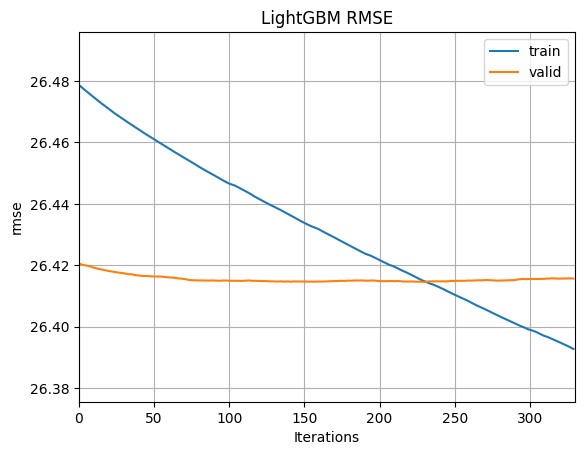

In [22]:
# 訓練データのスコア
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

RMSE_lgb = np.sqrt(mean_squared_error(y,pred_lgb))
print(f"LGB: RMSE score = {RMSE_lgb}")

# 学習曲線
lgb.plot_metric(evals_result_lgb,title="LightGBM RMSE",)

In [23]:
# 各FOLD、SEEDの平均
feature = 0
for i in range(7):
    feature += pd.DataFrame(models_lgb[i].feature_importance(importance_type="gain"),index=X.columns,columns=['importance'])/7

feature.sort_values("importance", ascending=False)[-20:]

,importance
CE_AudioLoudness2_MoodScore2,8049.274205
CE_TrackDurationMs_bin,7610.218541
CE_AudioLoudness2_RhythmScore2,6941.047294
CE_RhythmScore2_TrackDurationMs2,6600.110212
CE_MoodScore2_RhythmScore2,4954.414342
CE_LivePerformanceLikelihood_bin,4718.405692
CE_Energy2_RhythmScore2,4440.402902
CE_VocalContent_bin,3691.222866
CE_InstrumentalScore_bin,1591.799944
CE_MoodScore2_TrackDurationMs2,1442.457171


In [24]:
# 提出データ作成
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

sample_submission[TARGET] = pred_lgb_test
sample_submission.to_csv('submission.csv', index=False)
print('Submission file saved.')

Submission file saved.
